In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import re
import torch
from PIL import Image
import numpy as np
from resume_skills.dataset import DonutDataset
import ast
import json
from tqdm import tqdm

In [3]:
processor = DonutProcessor.from_pretrained("alakachr/donut-base-resume")
model = VisionEncoderDecoderModel.from_pretrained("alakachr/donut-base-resume")



In [29]:
image_path = '/data/ubuntu/resume_skills/data/train/images_val/Image_88_jpg.rf.1f5d91af6e5b903bc1b20335fd136a14.jpg'
image = Image.open(image_path)


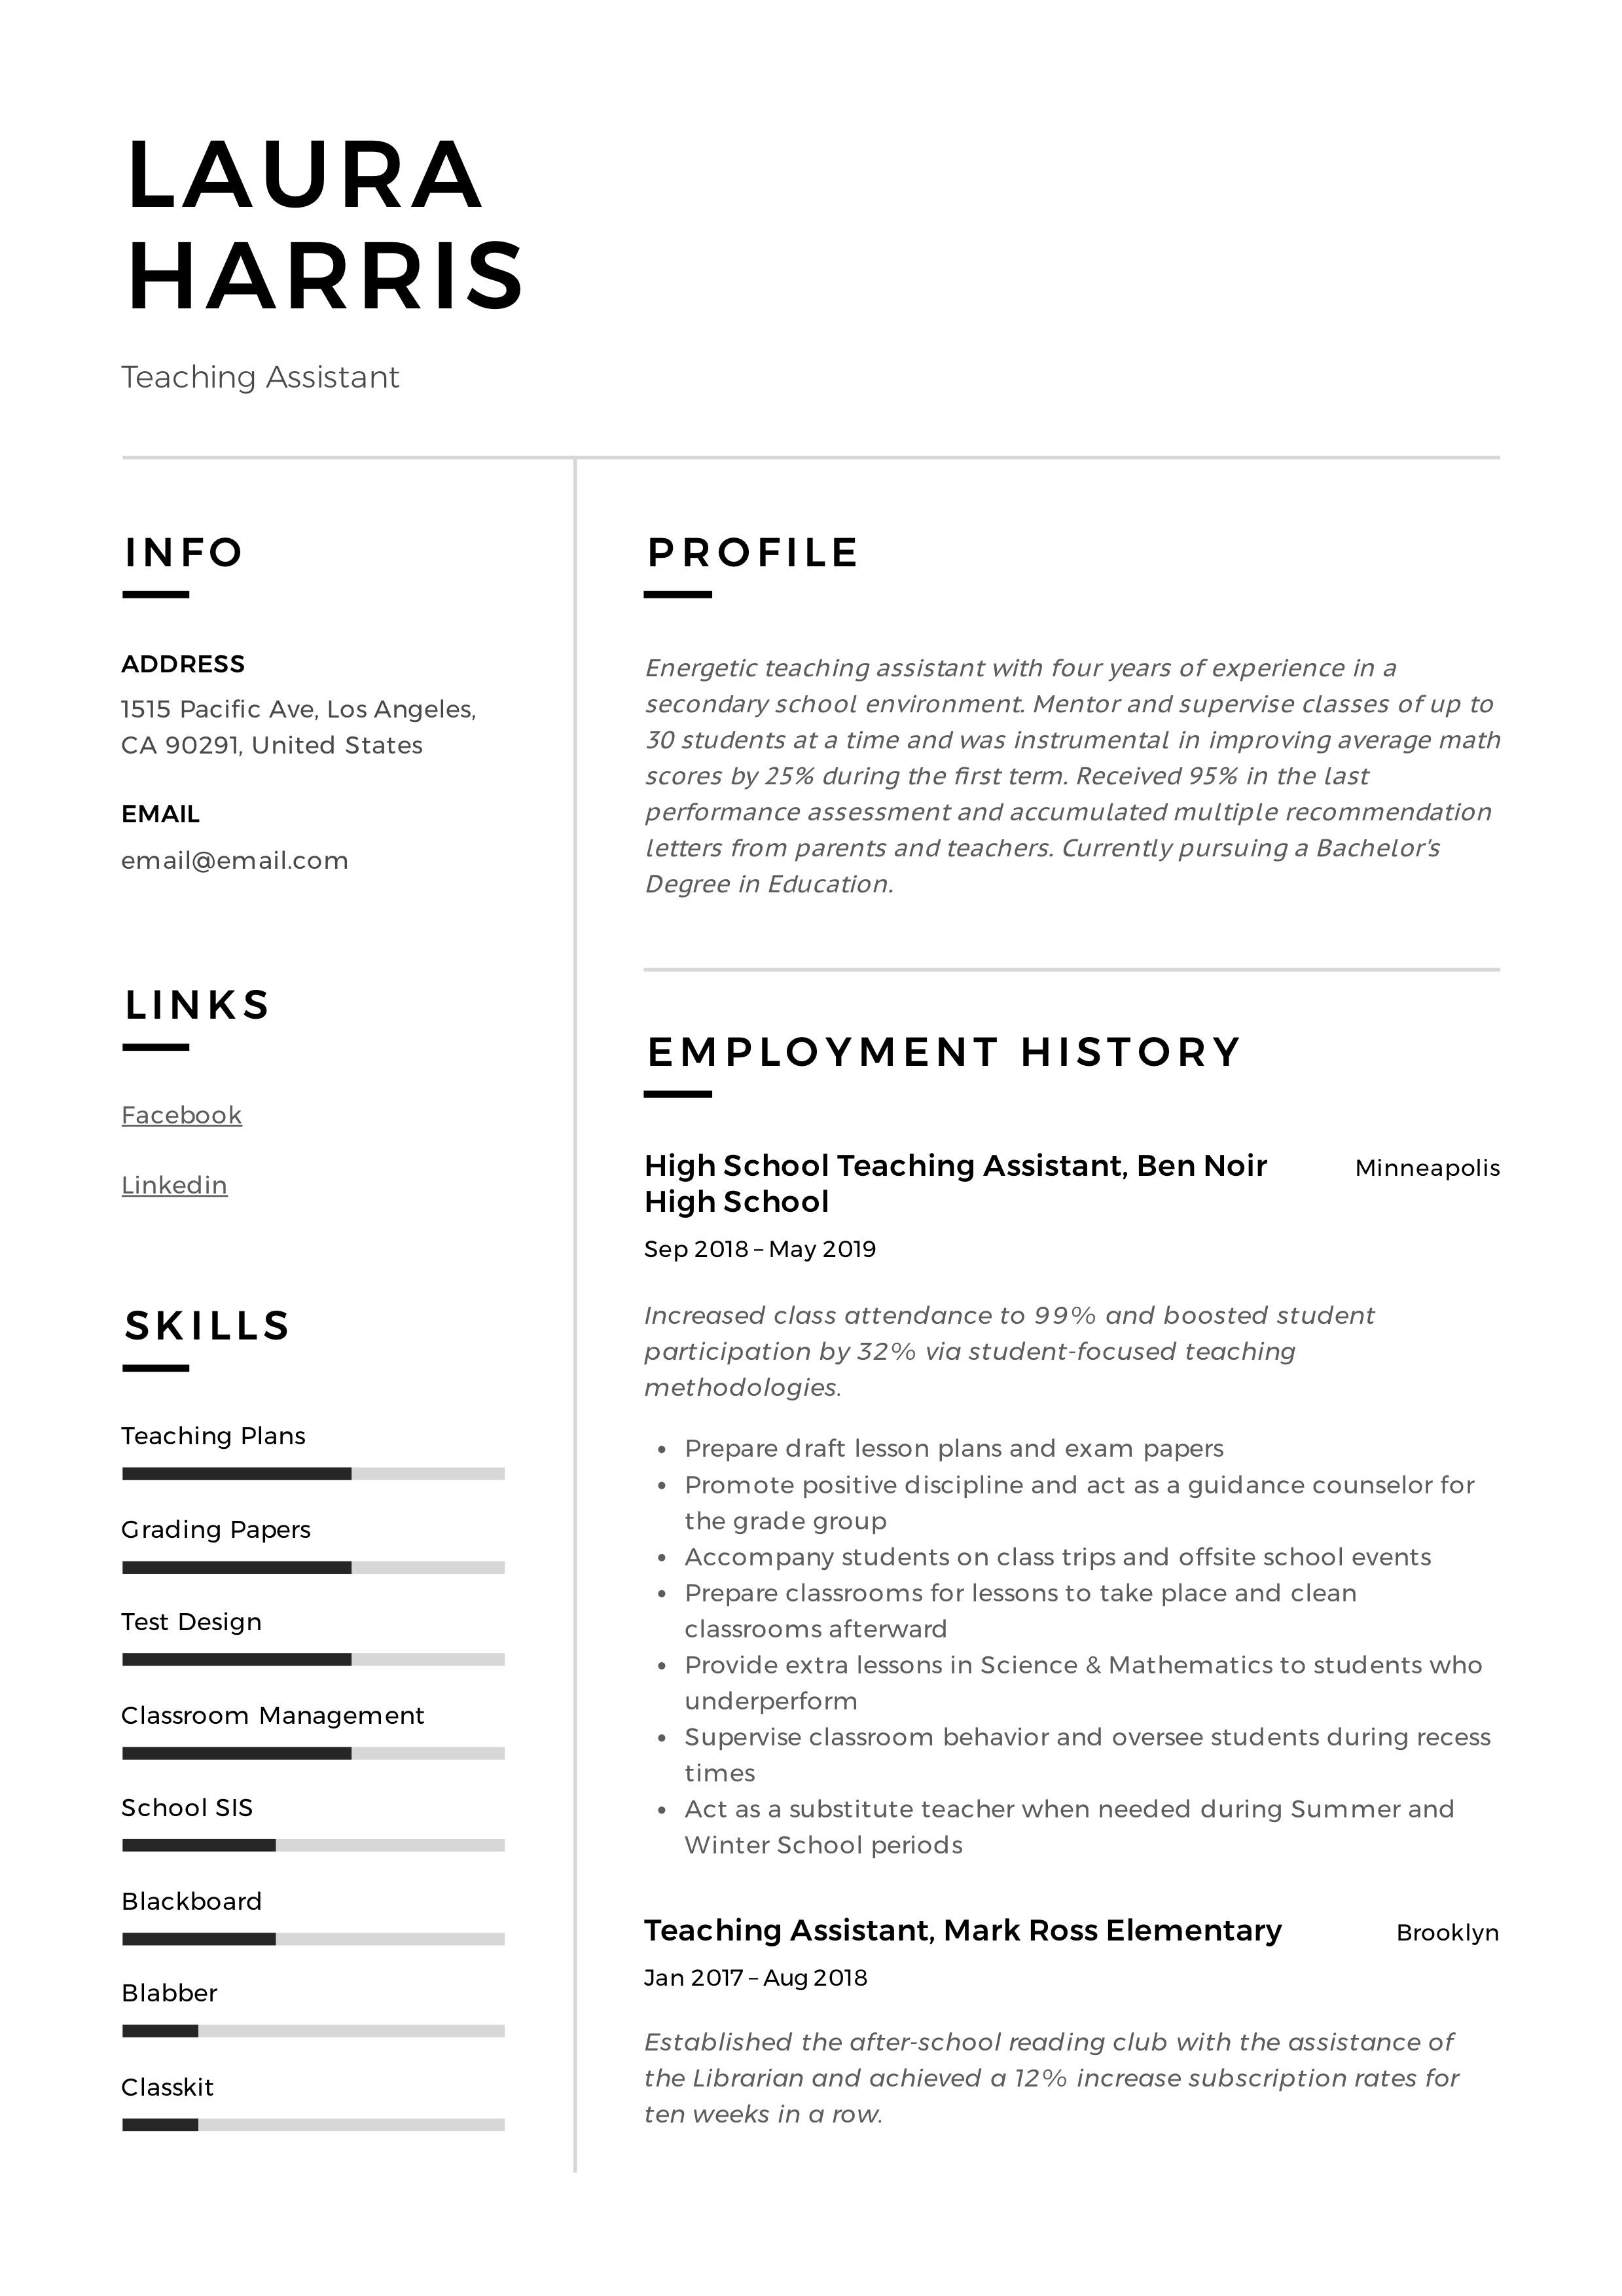

In [30]:
image

In [32]:

pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)


task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

torch.Size([1, 3, 960, 1280])


In [33]:

# Model prediction

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

[['Exetechnok', 0], ['Linkedin', 0], ['Treaching Plans', 0], ['Crading Papers', 0], ['Test Design', 0], ['Clussroom Management', 0], ['School SIS', 0], ['Blackboard', 0], ['Blakker', 0], ['Classkit', 0]]


In [43]:
def inference (pixel_values):
    pixel_values=pixel_values.unsqueeze(0)
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    outputs = model.generate(pixel_values.to(device),
                                   decoder_input_ids=decoder_input_ids.to(device),
                                   max_length=model.decoder.config.max_position_embeddings,
                                   early_stopping=True,
                                   pad_token_id=processor.tokenizer.pad_token_id,
                                   eos_token_id=processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,
                                   output_scores=True,)
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    print(sequence)
    return sequence 

In [18]:
val_dataset =DonutDataset(images_path = "/data/ubuntu/resume_skills/data/train/images_val")

/data/ubuntu/resume_skills/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
sample = dataset[0]
ast.literal_eval(sample["target_sequence"])

[['Photoshop', 0], ['Illustrator', 0], ['Ms Office', 0], ['Keynote', 0]]

In [53]:
def compute_stats(pred_sequence, target_sequence, threshold =10):
    
    pred_dict = {skill[0] : skill[1] for skill in pred_sequence}
    target_dict = {skill[0] : skill[1] for skill in target_sequence}

    TP, GT, FP, TP_skill0, GT_skill0, GT_skill,TP_skill = 0,0,0,0,0,0,0
    for skill in target_dict : 
        GT+=1
        if skill in pred_dict:
            TP +=1
            if target_dict[skill] ==0:
                GT_skill0+= 1
                if target_dict[skill] == pred_dict[skill]:
                    TP_skill0+=1
            else:
                GT_skill+=1
                if abs(target_dict[skill] - pred_dict[skill]) < threshold:
                    TP_skill+=1
    FP = len(set(pred_dict.keys()) - set(target_dict.keys()))
    return TP, GT, FP, TP_skill0, GT_skill0, GT_skill,TP_skill

In [54]:
# Compute Metrics
TP, GT, FP, TP_skill0, GT_skill0, GT_skill,TP_skill = 0,0,0,0,0,0,0

for sample in val_dataset:
    pred_sequence = inference(sample["pixel_values"])
    try: 
        pred_sequence= ast.literal_eval(pred_sequence)
    except:
        pred_sequence = []
    
    target_sequence = ast.literal_eval(sample["target_sequence"])

    TP_, GT_, FP_, TP_skill0_, GT_skill0_, GT_skill_,TP_skill_ = compute_stats(pred_sequence, target_sequence)
    
    TP+= TP_
    GT+= GT_
    FP+= FP_
    TP_skill0+=TP_skill0_
    GT_skill0+=GT_skill0_
    GT_skill=GT_skill_
    TP_skill += TP_skill_


    

[['Photoshop', 0], ['Illustrator', 0], ['Microsoft Windows', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0]]
[['Photoshop', 0], ['Illustrator', 0], ['Microsoft Windows', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0], ['Microsoft Excel', 0]]
[['Windows 7', 0], ['Windows Server', 0], ['Adobe Photoshop', 0], ['Success 3D', 0], ['Sketch', 0], ['Dreamwe', 0]]
[['Windows 7', 0], ['Windows Server', 0], ['Adobe Photoshop', 0], ['Success 3D', 0], ['Sketch', 0], ['Dreamwe', 0]]
[['MS Office', 0], ['Text here', 0], ['Text here', 0], ['Text here', 0]]
[['MS Office', 0], ['Text here', 0], ['Text here', 0], ['Text here', 0]]
[['Windows 7', 0], ['Windows Server', 0], ['Adobe Photoshop', 0], ['Success 3D', 0], ['Sketch', 0], ['Dreamwe', 0]]
[['MS Office', 0], ['Text here', 0], ['Text here', 0], ['Text here', 0]]
[['Exelismedégé

In [55]:
print("Recall for skill detection: ",TP/(GT) )
print("Precision for skill detection: ",TP/(TP+FP) )
print("Skill level recall for class 0 (no level):",TP_skill0/GT_skill0)
print("Skill level accuracy for other classes:",TP_skill/GT_skill)

Recall for skill detection:  0.2619047619047619
Precision for skill detection:  0.3728813559322034
Skill level recall for class 0 (no level): 1.0


ZeroDivisionError: division by zero

In [51]:
GT_skill0

32

In [52]:
TP_skill0

35